# Магазин "Стримчик". Анализ истории глобальных продаж компьютерных игр

План
1. Изучение информации
2. Предобрабтка данных
3. Исследование истории индустрии и крупнейших платформ
4. Исследование актуальных платформ и отзывов. Исследование жанров
5. Исследование региональных различий
6. Гипотезы
6. Выводы

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Изучение информации и переименование столбцов

In [2]:
games = pd.read_csv("games.csv")
games.columns = games.columns.str.lower()
display(games.head())
print(games.info())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


## Шаг 2. Предобработка данных

In [3]:
# Пропусков в столбце year_of_release очень мало, их можно просто удалить
games = games.dropna(subset = ['year_of_release'])
games.year_of_release = games.year_of_release.astype('int')

In [4]:
# Изучим уникальные значения столбца rating
print(games.rating.value_counts())

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64


Пропущенные значения запишем как отсутствие рейтинга 'no_rating'. Также запишем и RP, ведь RP - это rating pending, т.е "ожидает рейтинга".

In [5]:
games['rating'][games.rating.isna() == True] = 'no_rating'
games['rating'][games.rating == 'RP'] = 'no_rating'
print(games.rating.unique())

['E' 'no_rating' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC']


In [6]:
# Изучим уникальные значения в столбце user_score
print(games.user_score.unique())

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Сокращение tbd расшифровывается как to be decided. То есть, это по смыслу, пропущенное значение

In [7]:
# Присвоим всем tbd значение None, после чего приведем столбец к типу float
games['user_score'][games.user_score == 'tbd'] = None
games['user_score'] = games['user_score'].astype('float')

In [8]:
# Новый столбец с суммой продаж по всему миру
games['total_sales'] = games.na_sales + games.eu_sales + games.jp_sales + games.other_sales
print(games.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16446 non-null  object 
 11  total_sales      16446 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB
None


1. Типы данных изменены, где это было возможно. Избавились от пропусков в year_of_release и от tbd.

2. Пропуски в user_score и critic_score, видимо, случайны. Можно было бы заменить их на медианы, если бы нас интересовали только средние показатели, но мы собираемся изучать зависимость продаж от отзывов, и замена пропусков (более половины значений) на медианы в данном случае серьезно исказит распределение, и это не позволит адекватно оценить зависимость продаж от отзывов. Поэтому лучше оставить пропуски в покое.

## Шаг 3. Исследовательский анализ

Text(0, 0.5, 'Миллионы копий')

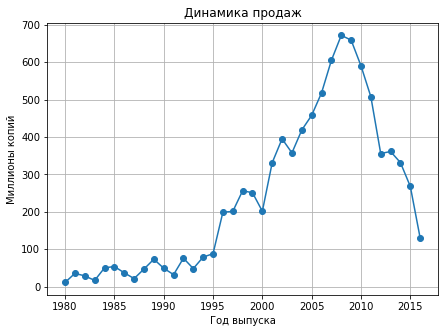

In [9]:
# Сгруппируем данные по годам и посчитаем сумму продаж для каждого из годов
sales_by_years = games.groupby('year_of_release')['total_sales'].sum()
# График динамики продаж
sales_by_years.plot(x = 'year_of_release', y = 'total_sales', style = 'o-', title = "Динамика продаж", figsize = (7, 5), grid=True)
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

Похоже, что расцвет игр пришелся на рубеж нулевых-десятых годов нового века. А тепрь показатели вернулись к состоянию рубежа 90-х- 2000-х. Индустрия пришла в упадок. В 2016 году - рекордное падение в два раза. Спад 2008-2016 гг. самый глубокий за период наблюдений.

### Исследование крупнейших платформ (времен расцвета индустрии)

In [10]:
# Количество проданных копий по платформам
sales_by_platform = games.groupby('platform').agg({'total_sales': sum})
# Добавим столбец для доли рына каждой платформы в процентах
sales_by_platform['sales_percent'] = (sales_by_platform['total_sales'] / sales_by_platform['total_sales'].sum()) * 100
sales_by_platform.sort_values(by = 'sales_percent', ascending = False, inplace=True)
display(sales_by_platform.head(10))

,total_sales,sales_percent
platform,,
PS2,1233.56,13.991033
X360,961.24,10.902381
PS3,931.34,10.563255
Wii,891.18,10.107760
DS,802.78,9.105128
PS,727.58,8.252210
PS4,314.14,3.562975
GBA,312.88,3.548684
PSP,289.53,3.283848


Самые крупные платформы - PS2, X360, PS3, Wii, DS, PS - в сумме имеют более 60 % рынка. Попробуем выделить их в отдельную таблицу и изучить как менялись продажи по годам.

In [11]:
# Сделаем срез по списку крупных платформ
my_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
big_platforms = games.query('platform in @my_list')
print(big_platforms.platform.unique())

['Wii' 'DS' 'X360' 'PS3' 'PS2' 'PS']


In [12]:
# Сводная таблица, в которой наблюдениями будут годы, столбцами - шесть платформ, а измеряемым показателем - сумма продаж
# По этой таблице будем делать график
big_platforms_pivot = big_platforms.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')

Text(0, 0.5, 'Миллионы копий')

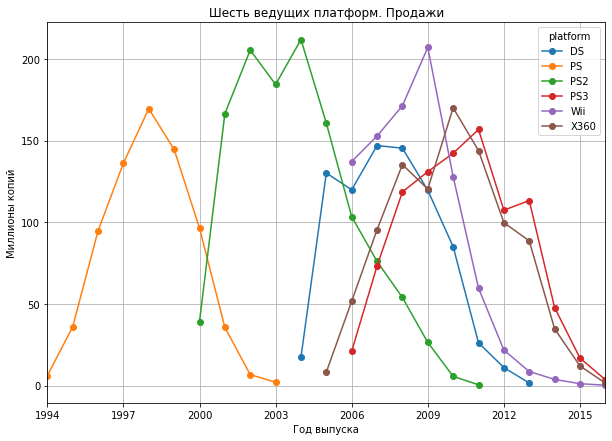

In [13]:
# График продаж для шести ведущих платформ
ax = big_platforms_pivot.plot(xlim = (1994, 2016), style = 'o-', title = "Шесть ведущих платформ. Продажи", figsize = (10, 7), grid=True)
ax.set_xticks(range(1994, 2016, 3))
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

У четырех платформ из шести самых крупных пики пришлись на период 2007-2011 гг. К 2013-2016 гг все эти платформы ушли в ноль. А начало их движения вверх пршлось на период 2004-2006. Таким образом, характерный цикл жизни платформы - это около 10 лет, с наивысшей точкой в середине. Чтобы понять какие платформы будут  переживать расцвет в районе 2017 года, попробуем посмотреть, какие платформы идут вверх, начиная с 2012-го.

### Исследование актуальных платформ

In [14]:
# Таблица новейших игр
latter_games = games.query('year_of_release > 2011')
# Сводная таблица для графика
latter_games_pivot = latter_games.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
display(latter_games_pivot)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Text(0, 0.5, 'Миллионы копий')

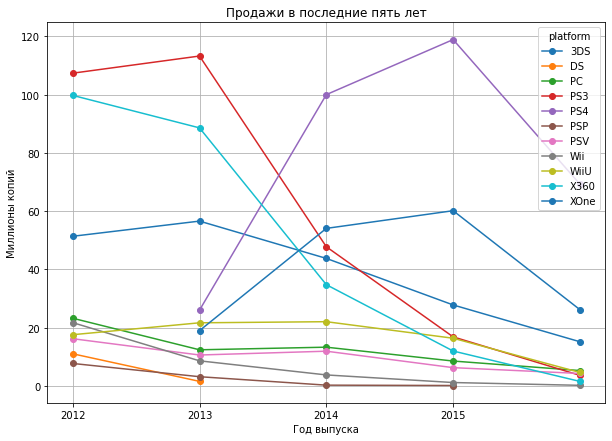

In [15]:
# График по продажам новейших игр 
ax = latter_games_pivot.plot(style = 'o-', title = "Продажи в последние пять лет", figsize = (10, 7), grid=True)
ax.set_xticks(range(2012, 2016))
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

Похоже, все-таки, что в упадок пришли не только те платформы, жизненный цикл, которых начинался в 2003-2007 гг, но и весь рынок в целом. За период 2012-2016 только 2 платформы поначалу росли, а остальные 9 стагнировали или падали. Начиная с 2016 - падают все. Для прогноза на 2017 год могут быть интересны в первую очередь еще относительно живые платформы, такие, как 3DS (15.14 млн копий за 2016 год), PS4 (69.25 млн) и XOne (26.15 млн).

In [16]:
# Список еще не совсем умерших платформ
actual_list = ['3DS', 'PS4', 'XOne']
# Срез по списку
three_actual_platforms = games.query('platform in @actual_list')
print(three_actual_platforms.platform.unique())

['PS4' '3DS' 'XOne']


In [17]:
# Сводная таблица. Наблюдение "имя-год" должно дать каждую отдельную игру. Столбцы - платформы, измеряемый показатель - продажи
# Таблица нужна, чтобы сделать диаграмму размаха.
actual_pivot = three_actual_platforms.pivot_table(index = ['name', 'year_of_release'], columns = 'platform', values = 'total_sales')

Text(0, 0.5, 'Миллионы копий')

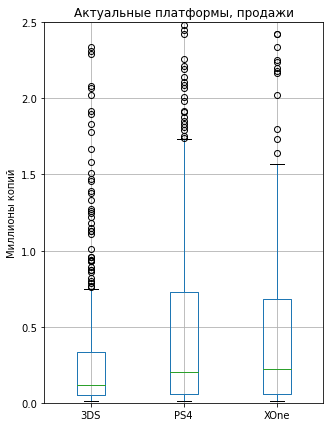

In [18]:
# Диаграмма размаха для продаж по каждой из трех относительно живых платформ
actual_pivot.boxplot(figsize=(5, 7))
plt.ylim(0, 2.5)
plt.title('Актуальные платформы, продажи')
plt.ylabel('Миллионы копий')

У самой популярной платформы, PS4, 75% игр расходятся тиражом не более 750 тысяч копий. Значения, превышающие 1.75 млн можно считать выбросами. У 75% игр платформы XOne продается не более 700 тысяч копий, значения выше 1.6 млн - выбросы. 75% игр 3DS расходятся в количестве не более 400 тысяч копий. Более 750 тысяч - выбросы. 

### Исследование отзывов критиков и пользователей

Коэффициент корреляции: продажи платформы PS4 и отзывы пользователей: -0.03195711020455645


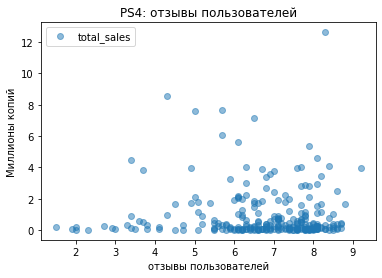

In [19]:
# Продажи и отзывы критиков и пользователей
# Функция для создания диаграмм рассеяния и подсчета коэффициента корреляции. Аргументы - платформа и тип отзывов
# (можно подставить 'critic_score' или 'user_score')
def plot_platform(platform, score):
    if score == 'user_score':
        text = "отзывы пользователей"
    else:
        text = "отзывы критиков"
    # Срез по платформе
    new_table = games[games.platform == platform]
    # Вывод коэффициента корелляции для продаж платформы и отзывов критиков
    print("Коэффициент корреляции: продажи платформы " + platform + " и " + text + ": ", end='')
    print(new_table[score].corr(new_table['total_sales']))
    # Диаграмма рассеяния
    ax = new_table.plot(x = score, y = 'total_sales', style = 'o', title = platform + ': ' + text, alpha = 0.5)
    plt.xlabel(text)
    plt.ylabel("Миллионы копий")
    return ax

# Продажи PS4 и отзывы пользователей
plot_platform('PS4', 'user_score')

Похоже, что продажи игр платформы PS4 от оценок пользователей никак не зависят. Наиболее плотный участок на графике в районе оценок 7-8 с небольшим количеством продаж. Видимо, в основном игры покупает небольшая, но преданная группа пользователей.

Коэффициент корреляции: продажи платформы PS4 и отзывы критиков: 0.4065679020617815


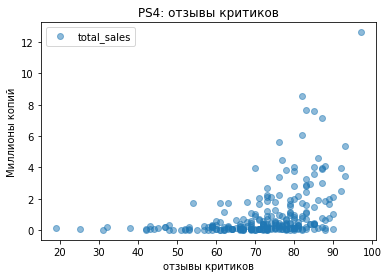

In [20]:
# Отзывы критиков
plot_platform('PS4', 'critic_score')

Наблюдается небольшая, слабая, связь между оценками критиков и продажами игр PS4. Впрочем, игры, продаваемые хорошо, низких оценок критиков не удостаиваются. Так или иначе, самое плотное место на этом графике там же, где и на предыдущем. Игры на твердую "четверку", выпускаемые не очень большим тиражом.

Коэффициент корреляции: продажи платформы XOne и отзывы пользователей: -0.06892505328279416


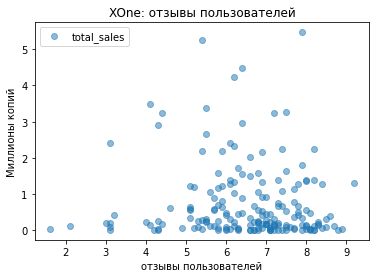

In [21]:
# Продажи XOne и отзывы пользователей
plot_platform('XOne', 'user_score')

Снова никакой взаимосвязи между продажами и мнением потребителей. Может быть, те, кто оставляют отзывы, просто не представляют репрезентативно всех покупателей, то есть это особые люди, которым не лень писать отзывы?

Коэффициент корреляции: продажи платформы XOne и отзывы критиков: 0.4169983280084016


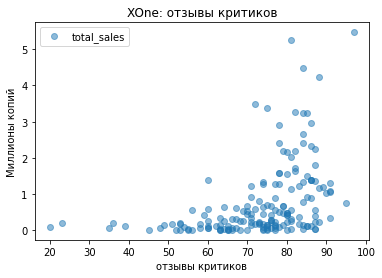

In [22]:
# Отзывы критиков
plot_platform('XOne', 'critic_score')

От мнения критиков, видимо, что-то зависит, по крайней мере, среди тех игр, которые проданы в количестве более млн копий, низких оценок практически нет.

Коэффициент корреляции: продажи платформы 3DS и отзывы пользователей: 0.22207843643390887


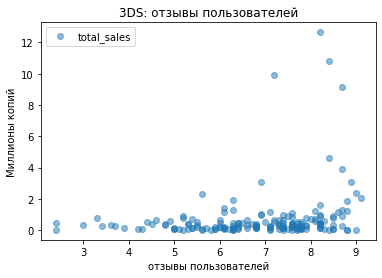

In [23]:
# 3DS и отзывы пользователей
plot_platform('3DS', 'user_score')

Коэффициент корреляции: продажи платформы 3DS и отзывы критиков: 0.34873973059848357


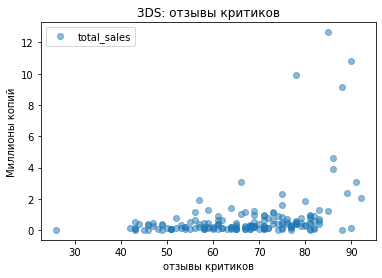

In [24]:
# Отзывы критиков
plot_platform('3DS', 'critic_score')

В целом, та же картина: от отзывов мало что зависит. Единственное, что для игр 3DS не такой большой разрыв между значимостью мнения пользователей и мнения критиков. Должно быть, продаж мало, и интерес критиков к платформе угасает.

### Исследование жанров

In [25]:
# Жанры: количество игр, суммарное количество проданных копий игр для каждого жанра,
# среднее количество проданных копий одной игры каждого жанра

grouped_by_genre = latter_games.groupby('genre', as_index = False).agg({'name': 'count', 'total_sales': 'sum'})
sales_mean = latter_games.groupby('genre', as_index = False).agg({'total_sales': 'mean'})
grouped_by_genre = grouped_by_genre.rename(columns = ({'name': 'games', 'total_sales': 'sales_per_genre'}))
sales_mean = sales_mean.rename(columns = {'total_sales': 'average_sales_per_game_of_the_genre'})
grouped_by_genre = pd.merge(grouped_by_genre, sales_mean, on='genre')
grouped_by_genre.sort_values(by = 'sales_per_genre', ascending = False, inplace=True)
display(grouped_by_genre)

,genre,games,sales_per_genre,average_sales_per_game_of_the_genre
0,Action,1031,441.12,0.427856
8,Shooter,235,304.73,1.296723
7,Role-Playing,370,192.80,0.521081
10,Sports,268,181.07,0.675634
3,Misc,192,85.04,0.442917
4,Platform,85,61.00,0.717647
6,Racing,115,53.50,0.465217
2,Fighting,109,44.49,0.408165
9,Simulation,80,35.12,0.439000
1,Adventure,302,29.43,0.097450


Text(0, 0.5, '')

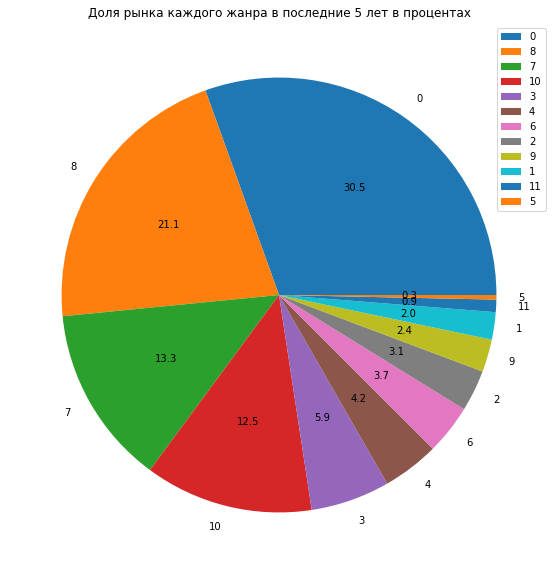

In [26]:
# "Пирог". Доля рынка каждого жанра в последние 5 лет
grouped_by_genre.plot(kind = 'pie', y = 'sales_per_genre', figsize=(10,10), title = 'Доля рынка каждого жанра в последние 5 лет в процентах', autopct = '%.1f')
plt.ylabel('')

В последние пять лет (с 2012 по 2016 г включительно) более половины всех копий игр было продано в жанрах Action и Shooter. Если добавить жанры Role-Playing и Sports, то получится почти 80% всех проданных копий. Между тем, среди жанров, в которых продажи идут хорошо, есть такой, например, жанр, как Platform. В среднем игра этого жанра расходилась в эти пять лет тиражом чуть меньше 720 тысяч копий. Однако игр в этом жанре выпускалось мало. В результате жанр, идущий на втором месте по среднему количеству проданных копий одной игры, обеспечил всего 4% всех проданных копий. Возможно, у этого жанра есть большой нереализованный потенциал. Также можно отметить, что жанр Shooter имеет самое большое среднее количество проданных копий одной игры (причем с большим отрывом), но при этом занимает лишь второе место по общему числу продаж. Это значит, возможно, что и здесь есть нереалзованный потенциал.

## Шаг 4. Портрет пользователя каждого региона

### Топ-5 платформ в каждом регионе

In [27]:
# Сводная таблица продаж в Америке по платформам
america_latter_games_pivot = latter_games.pivot_table(index = 'year_of_release', columns = 'platform', values = 'na_sales', aggfunc = 'sum')
display(america_latter_games_pivot)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,17.11,4.02,8.01,39.88,NaN,0.13,5.94,10.89,8.89,58.39,NaN
2013,15.56,0.57,3.88,41.45,10.13,0.00,2.52,4.48,9.85,53.36,11.85
2014,12.33,NaN,3.51,16.39,34.75,0.00,1.98,1.59,10.50,20.25,30.97
2015,6.17,NaN,2.36,4.99,42.37,0.00,0.39,0.43,6.76,7.36,36.03
2016,4.14,NaN,1.36,0.67,21.49,NaN,0.15,0.06,2.10,0.69,14.27


Text(0, 0.5, 'Миллионы копий')

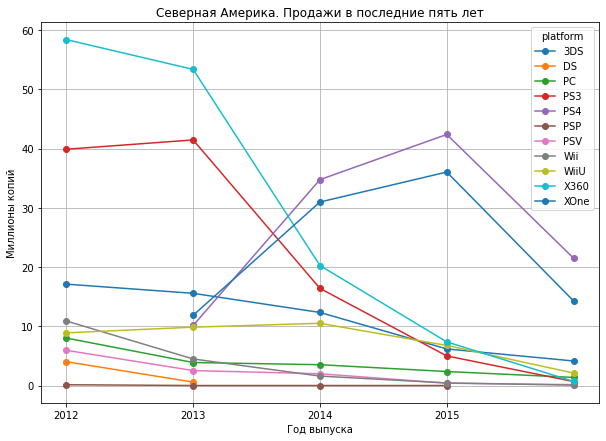

In [28]:
# График продаж в Америке в последние пять лет
ax = america_latter_games_pivot.plot(style = 'o-', title = "Северная Америка. Продажи в последние пять лет", figsize = (10, 7), grid=True)
ax.set_xticks(range(2012, 2016))
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

Североамериканский топ-5 платформ (по состоянию на 2016 год): PS4, XOne, 3DS, WiiU, PC. Около половины всех продаж приходится на PS4. А вместе с XOne они контролировали в 2016 году более трех четвертей североамериканского рынка.

In [29]:
# Сводная таблица продаж в Европе по платформам
europe_latter_games_pivot = latter_games.pivot_table(index = 'year_of_release', columns = 'platform', values = 'eu_sales', aggfunc = 'sum')
display(europe_latter_games_pivot)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,11.68,2.68,12.40,39.05,NaN,0.25,5.26,5.99,5.28,32.00,NaN
2013,14.84,0.85,7.39,42.27,11.05,0.17,2.57,3.34,6.70,27.03,5.34
2014,8.73,NaN,8.87,18.24,46.50,0.00,2.45,1.86,6.66,11.28,18.15
2015,5.06,NaN,5.57,6.04,51.76,0.00,0.69,0.62,5.01,3.50,18.47
2016,2.33,NaN,3.53,1.26,31.78,NaN,0.39,0.11,1.48,0.71,9.63


Text(0, 0.5, 'Миллионы копий')

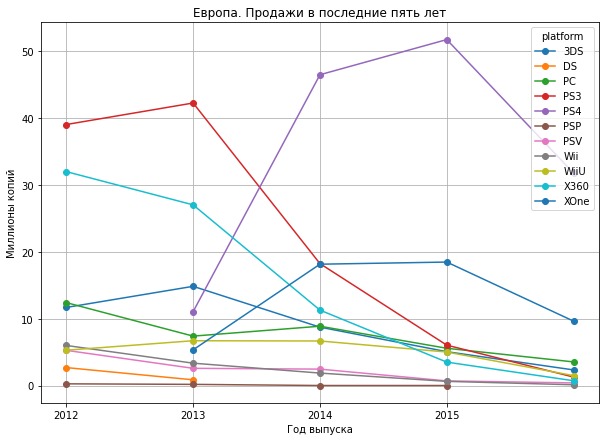

In [30]:
# График продаж в Европе в последние пять лет
ax = europe_latter_games_pivot.plot(style = 'o-', title = "Европа. Продажи в последние пять лет", figsize = (10, 7), grid=True)
ax.set_xticks(range(2012, 2016))
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

Европейский топ_5: PS4, XOne, PC, 3DS, WiiU. В Европе в 2016 году PS4 занимал более половины рынка. Так же, как в Америке, на эту платформу вместе с XOne прходилось более трех четвертей продаж игр в Европе.

In [31]:
# Сводная таблица продаж в Японии по платформам
japan_latter_games_pivot = latter_games.pivot_table(index = 'year_of_release', columns = 'platform', values = 'jp_sales', aggfunc = 'sum')
display(japan_latter_games_pivot)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,19.98,3.72,0.0,11.94,NaN,7.18,2.45,3.34,2.13,1.06,NaN
2013,23.57,0.00,0.0,12.13,0.94,2.93,4.05,0.05,3.57,0.43,0.02
2014,20.69,NaN,0.0,6.25,2.97,0.24,6.13,0.00,3.19,0.08,0.14
2015,15.52,NaN,0.0,3.67,6.31,0.12,4.85,0.00,3.45,0.00,0.17
2016,8.03,NaN,0.0,1.30,5.74,NaN,3.56,0.00,0.67,0.00,0.01


Text(0, 0.5, 'Миллионы копий')

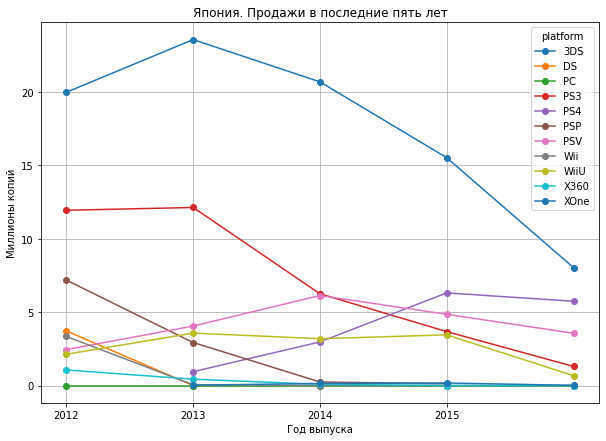

In [32]:
# График продаж в Японии в последние 5 лет
ax = japan_latter_games_pivot.plot(style = 'o-', title = "Япония. Продажи в последние пять лет", figsize = (10, 7), grid=True)
ax.set_xticks(range(2012, 2016))
plt.xlabel('Год выпуска')
plt.ylabel('Миллионы копий')

Японский топ-5: 3DS, PS4, PSV, PS3, WiiU. В Японии другой лидер - 3DS, при этом такого однозначного доминирования одной платформы, как в Северной Америке и Европе, нет. Контроль над тремя четвертями рынка принадлежит первым трем платформам, а не первым двум. При этом в числе лидеров оказалась платформа PSV, не заметная в Америке и Европе. PC, бывшая, в числе лидеров на Западе, в Японии не представлена.

### Топ-5 популярных жанров в разных регионах

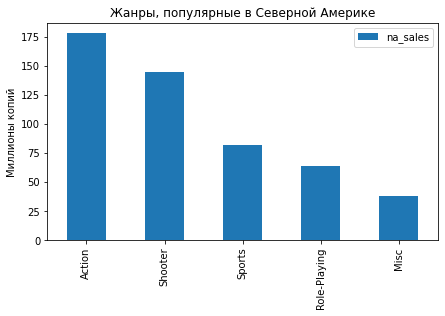

In [33]:
# Функция для определения пяти самых популярных жанров
def find_top_five(sales, title):
    popular_genres = latter_games.groupby('genre').agg({sales: 'sum'})
    popular_genres.sort_values(by = sales, ascending = False, inplace=True)
    ax = popular_genres.head().plot(kind = 'bar', figsize = (7, 4), title = title)
    plt.xlabel('')
    plt.ylabel('Миллионы копий')
    return ax

# Жанры, популярные в Северной Америке
find_top_five('na_sales', "Жанры, популярные в Северной Америке")

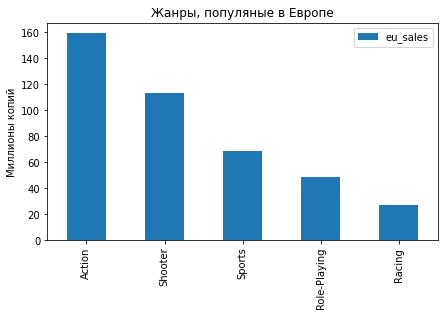

In [34]:
# Жанры, популяные в Европе
find_top_five('eu_sales', "Жанры, популяные в Европе")

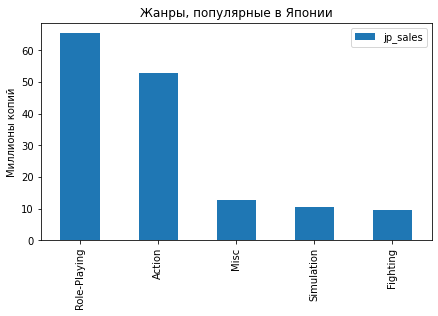

In [35]:
# Жанры, популярные в Японии
find_top_five('jp_sales', "Жанры, популярные в Японии")

В Америке и в Европе пятерки популярных жанров почти полностью совпадают. Разница лишь в том, что в Америке на пятом месте идет жанр Misc, а в Европе - Racing. В остальном практически полное совпадение: зазоры между местами с первого по четвертое примерно одинаковые. В целом, можно сказать, что вкусы европейских любителей игр мало отличаются от вкусов американцев. Япония же сильно отличается от западных стран: здесь на первое место вышел жанр Role-Playing, который был на четвертом месте в странах Запада, японцы равнодушны к жанру Shooter, его нет в топ-5, тогда как в западных странах он на втором месте. Также им не интересен жанр Sports, но зато есть Fighting  и Simulation, которых нет в топ-5 стран Запада.

### Рейтинг ESRB и продажи по регионам

In [36]:
# маркировки ESRB, которые в выборке встречаются достаточно часто
rating_list = ['E', 'T', 'M', 'E10+', 'no_rating']
esrb_latter_games = latter_games.query('rating in @rating_list')

# Сгруппируем данные по рейтингу и вычислим среднее число
# продаваемых копий игры c данной маркировкой ESRB для каждого региона 
grouped_by_esrb = esrb_latter_games.groupby('rating').agg({'na_sales': 'mean', 'eu_sales': 'mean', 'jp_sales': 'mean'})
transp_esrb = grouped_by_esrb.T
display(transp_esrb)

rating,E,E10+,M,T,no_rating
na_sales,0.289544,0.247386,0.465000,0.160243,0.081027
eu_sales,0.286152,0.180948,0.389478,0.128544,0.071765
jp_sales,0.071722,0.026765,0.042570,0.063155,0.085365


Text(0, 0.5, 'Миллионы копий')

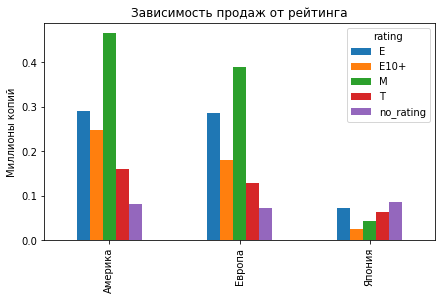

In [37]:
ax = transp_esrb.plot(kind = 'bar', figsize = (7, 4), title = 'Зависимость продаж от рейтинга')
ax.set_xticklabels(['Америка', "Европа", "Япония"])
plt.ylabel('Миллионы копий')

Игры с различными рейтингами ESRB в среднем по-разному продаются. Например, в Америке и Европе самые большие продажи у игр с маркировкой M (mature) - для взрослых. В Японии лучше всего продаются игры для всех (E) и для подростков (T). Отсутствие рейтинга ('no_rating') сказывается на продажах в Европе и Америке - негативным образом, у таких игр проодаж заметно меньше, чем у маркированных. На продажи в Японии это не влияет: среднее число реализованных копий игр без рейтинга в Японии даже чуть-чуть выше, чем у игр с рейтингом.

## Шаг 5. Проверка гипотез

### Гипотеза: средние пользовательские рейтинги Xbox One и PC одинаковые

Нас интересует, равно ли среднее двух генеральных совокупностей. Нулевая гипотеза: средние рейтинги платформ XOne и PC равны. Альтернативная гипотеза: средние рейтинги платформ XOne и PC различаются.

In [38]:
# Срез данных для платформы XOne
x_one = latter_games[latter_games.platform == 'XOne']
x_one = x_one.dropna()

# Срез данных для платформы PC
pc = latter_games[latter_games.platform == 'PC']
pc= pc.dropna()

# Проверка дисперсий
print(x_one.user_score.var())
print(pc.user_score.var())

1.7963991130820411
2.687800165751582


Дисперсии обеих выборок различаются.

In [39]:
# Вычисление p-значения и сравнение его с пороговым значением статистической значимости
result = st.ttest_ind(x_one['user_score'], pc['user_score'], equal_var = False)
alpha = 0.05
print(result.pvalue)
print(alpha >= result.pvalue)

0.5926561176517491
False


P-значение сильно больше, чем порог статистической значимости. Нулевую гипотезу нельзя отвергнуть.

### Гипотеза: средние пользовательские рейтинги жанров Action  и Sports разные

Нулевая гипотеза: средние рейтинги жанров экшн и спортс - равны. Альтернативная гипотеза: средние рейтинги этих жанров одинаковы.

In [40]:
# Срез для Action
action = latter_games[latter_games.genre == 'Action']
action = action.dropna()

# Срез для Sports
sports = latter_games[latter_games.genre == 'Sports']
sports = sports.dropna()

# Дисперсии
print(action.user_score.var())
print(sports.user_score.var())

1.7516700502706886
1.985888551165147


Дисперсии выборок различаются.

In [41]:
# Вычисление p-значения и сравнение его с пороговым значением статистической значимости
result2 = st.ttest_ind(action['user_score'], sports['user_score'], equal_var = False)
alpha = 0.05
print(result2.pvalue)
print(alpha >= result2.pvalue)

5.858072645452818e-14
True


P-значение меньше, чем порог статистической значимости. Нулевую гипотезу можно отвергнуть. Средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports.

## Общий вывод

1. Индустрия игр переживает глубокий кризис.
2. Жизненный цикл платформы - около 10 лет.
3. Западные пользователи отличаются от японских: им нравятся разные жанры игр, набор популярных платформ несколько различается.
4. Потенциально прибыльными, возможно являются некоторые жанры, в которых пока что мало выпущено игр, но при этом те игры, которые выпущены хорошо продаются: например, Platform или Sports. Также, видимо, есть еще нераскрытый потенциал у жанра Shooter. Но не для Японии.
5. Анализ отзывов критиков и пользователей не дал значимых результатов, в отличие от анализа рейтинга ESRB.